##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds #### بعضی از داده های مهم هستند که خودشون دارند و لازم نیست بری یوآرال شو بیاری
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt   #### تابعی برای رسم نمودارها


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test'] #### چون سوپروایز هست هر بار هر ترین و با هدفش میاره، یعنی Yش

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):  ### مینی بچ نکرده و هر بار تیک، یه جمله رو فقط برمیگردونه
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1): ### انتظار داریم حالا یه مینی بچ برگردونه
  print('texts: ', example.numpy()[:3]) ### حالا تو این مینی بچ 3 تا جمله رو بگیره
  print()
  print('labels: ', label.numpy()[:3]) ### و سه تا لیبل

texts:  [b'There was a Bugs Bunny cartoon titled "Baby Buggy Bunny" that was EXACTLY this plot. Baby-faced Finster robbed a bank and the money in the carriage rolled away and fell into Bug\'s rabbit hole. He dressed up as a baby to get into Bugg\'s hole to retrieve the money. The scene in "Little Man" where he\'s looking in the bathroom mirror shaving with a cigar in his mouth is straight from the cartoon. This was a hilarious 5-minute cartoon; not so much an entire movie. If you are really interested in this, buy the Bugs Bunny DVD. It\'s was much more original the first time (1954). Plus you\'ll get a lot more classic Bugs Bunny cartoons to boot!'
 b"Tatie Danielle is all about a ghastly old hag who torments her loving and oblivious family out of sheer spite. There's a bit of subtext that might be about France's colonial past but it's mostly just Danielle doing the sorts of things (like deliberately abandoning a small child in a park) that would soon have a man picking up his teeth w

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [12]:
### طول جمله به اندازه بزرگترین جمله موجوده
VOCAB_SIZE = 1000 #### به 1000 تا کلمه توکن بده
encoder = tf.keras.layers.TextVectorization( ###فقط استاندارد کردن و بای دیفالت زده، توکن هم که اینجا آورده که در مرحله بعد بیاد وکتور کنه
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))### میره براساس موادر بالا وکتور میکنه و با این عبارته فقط تکیت و میاره نه لیبل

In [14]:
encoder.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [25]:
len(encoder.get_vocabulary())

1000

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [15]:
encoded_example = encoder(example)[:3].numpy() ###هر اگزمبل شامل یک مینی بچ هست که از این سه جمله اول رو میخواد بگیر
encoded_example
#### من نمیدونم سایز هر جمله چه قدره، میتونم شیپ بزنم ببینم و در این مواقع میره سراغ بزرگترین جمله و همه رو با اون هم اندازه می کنه

array([[ 48,  14,   4, ...,   0,   0,   0],
       [  1,   1,   7, ...,   0,   0,   0],
       [ 10, 364,  51, ...,   0,   0,   0]])

In [17]:
encoded_example.shape #### سایز بزرگترین جمله رو میخواستم بدونم

(3, 1183)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [24]:
for n in range(1):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

  ### اینجا میخواسته جمله ای که قبل و بعد انکد رو ببینه

Original:  b'There was a Bugs Bunny cartoon titled "Baby Buggy Bunny" that was EXACTLY this plot. Baby-faced Finster robbed a bank and the money in the carriage rolled away and fell into Bug\'s rabbit hole. He dressed up as a baby to get into Bugg\'s hole to retrieve the money. The scene in "Little Man" where he\'s looking in the bathroom mirror shaving with a cigar in his mouth is straight from the cartoon. This was a hilarious 5-minute cartoon; not so much an entire movie. If you are really interested in this, buy the Bugs Bunny DVD. It\'s was much more original the first time (1954). Plus you\'ll get a lot more classic Bugs Bunny cartoons to boot!'
Round-trip:  there was a [UNK] [UNK] [UNK] [UNK] baby [UNK] [UNK] that was exactly this plot [UNK] [UNK] [UNK] a [UNK] and the money in the [UNK] [UNK] away and [UNK] into [UNK] [UNK] [UNK] he [UNK] up as a baby to get into [UNK] [UNK] to [UNK] the money the scene in little man where hes looking in the [UNK] [UNK] [UNK] with a [UNK] in hi

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [26]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding( #### به تعداد توکن ها
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), ### منظورش استیت 64 تایی هست که چون از هر دو جهت بررسی میکنیم دو تا داریم و میشه 128 چون کانکتنیت میشه
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [27]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [32]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.7049749]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [33]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 68ms/step
[0.70497495]


Compile the Keras model to configure the training process:

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [31]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 104ms/step - loss: 0.6240 - accuracy: 0.5819 - val_loss: 0.4338 - val_accuracy: 0.7927
Epoch 2/10
391/391 [==============================] - 28s 72ms/step - loss: 0.3904 - accuracy: 0.8238 - val_loss: 0.3628 - val_accuracy: 0.8333
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3368 - accuracy: 0.8538 - val_loss: 0.3433 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3206 - accuracy: 0.8625 - val_loss: 0.3449 - val_accuracy: 0.8604
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3147 - accuracy: 0.8655 - val_loss: 0.3410 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3091 - accuracy: 0.8659 - val_loss: 0.3261 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3068 - accuracy: 0.8675 - val_loss: 0.3395 - val_accuracy

In [34]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3184 - accuracy: 0.8630
Test Loss: 0.3183596730232239
Test Accuracy: 0.8629599809646606


(0.0, 0.6402286171913147)

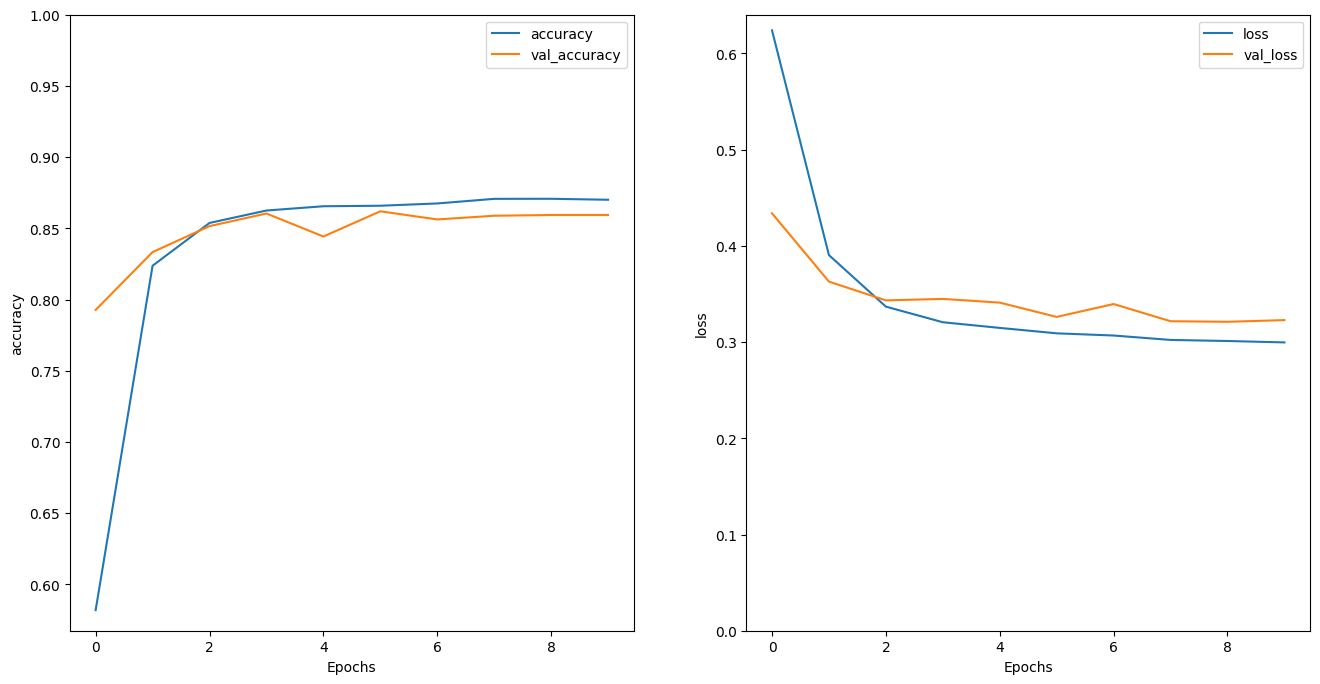

In [35]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
